# Pandeia for WFIRST Imaging

How to cite this code:

> Klaus M. Pontoppidan ; Timothy E. Pickering ; Victoria G. Laidler ; Karoline Gilbert ; Christopher D. Sontag, et al.
"Pandeia: a multi-mission exposure time calculator for JWST and WFIRST", Proc. SPIE 9910, Observatory Operations: Strategies, Processes, and Systems VI, 991016 (July 15, 2016); doi:10.1117/12.2231768; http://dx.doi.org/10.1117/12.2231768

This is an introductory notebook that provides an easy-to-use interface for making Pandeia ETC calculations. This notebook only supports WFIRST imaging and has simplified some configuration options.  

Refer to the documentation links provided within the *Help* menu for general information on the Jupyter/IPython notebook interface and useful keyboard short-cuts.  The key things you need to know are that you must use ``Shift-Enter`` to execute a cell and that once a cell is executed, all data defined within it becomes available to all other cells. (You can also click the <i class="fa-step-forward fa"></i> icon in the toolbar to run a cell.)

This first cell sets up the imports and configuration that are required:  

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sys
import os
import numpy as np
import matplotlib
from matplotlib import style
style.use('ggplot')  # see http://matplotlib.org/users/style_sheets.html
                     # for info on matplotlib styles
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

# the first pandeia import is required to run the GUI. the others are provided to
# allow manual running of calculations and loading/saving of inputs or results.
from toolbox.etc.gui import PandeiaWFIRSTCalculator
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.io_utils import read_json, write_json

The next cell instantiates and runs the GUI.  The inputs for ``Source type`` and ``SED type`` will change dynamically depending on which drop-down entry is selected.  For simplicity's sake, only a single source at a time is currently supported. 

This source can either be a point source or extended.  Extended sources require extra configuration:

- Surface brightness profile
     - Gaussian — $I \propto e^{r^{-2}}$
     - Exponential — $I \propto e^{r^{-1}}$
     - de Vaucouleurs — $I \propto e^{r^{-0.25}}$
- Major axis scale length of the surface brightness profile (sigma in the case of Gaussian)
- Ellipticity of the source
- Position angle of the major axis (measured CCW from horizontal)

Source flux can currently only be specified in $F_{\nu}$ units such as ``mJy`` or AB magnitudes at a specific wavelength. 

There are several options for configuring the spectral energy distribution (SED) of the source:

- Power-law — $F \propto \lambda^{index}$
- Blackbody
- Star — As calculated from the Phoenix models. Each entry shows the spectral type, $T_{eff}$, and $log\ g$ used.
- Extragalactic — Compiled from the Brown et al. (2014) catalog of integrated galaxy spectra

In each case, the specified redshift is applied to the SED.

Currently, the WFIRST wide-field imager (WFI) is the only available instrument.  Its configuration parameters are:

- Filter
- Readmode — Currently modeled after JWST's NIRCam and specifies how many reads/skips there are per group
- Subarray — Geometry of the region of the detector being read-out
- Groups — Number of groups per integration
- Integrations — Number of integrations to perform
- Exposures — Number of sets of integrations to perform

The extracted flux and signal-to-noise ratio are calculated via aperture photometry. The source region is circular with the configured radius and the background region is annular with the configured inner and outer radii.  The GUI automatically checks these radii to prevent overlap.  For example, if you increase aperture radius, the annulus radii will automatically adjust accordingly.  The display of these radii on the 2D plots can be toggled by clicking *Overlay*.

To run the calculation, click *Calculate* and the results will be displayed below.  You can select what to display in the plots via the two pull-downs: *1D Plot* and *2D Image*.

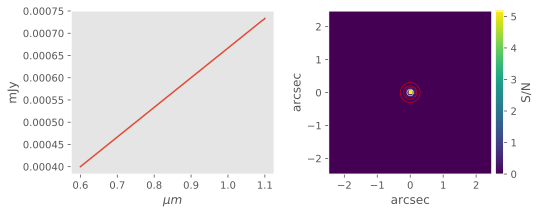

In [12]:
g = PandeiaWFIRSTCalculator()
g.display()

It is possible to extract the full input and output information from the ETC calculation. The ETC input and output are both stored as dictionaries, which can be directly manipulated. 

In [13]:
g.run_engine()
calculation = g.calculation_input
result = g.calculation_result

As an example, we will create a new source and add it to our ETC scene. First, we import a method to create a default source.

In [14]:
from pandeia.engine.calc_utils import build_default_source
s = build_default_source()

Then, we move the source up by 1 arcsecond, change its flux to ABmag = 24 and make it extended.

In [15]:
s['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
s['spectrum']['normalization']['norm_flux'] = 21.
s['shape']['geometry'] = 'sersic'
s['shape']['sersic_index'] = 1.  # exponential disk
s['shape']['major'] = 0.4  # major axis in arcseconds
s['shape']['minor'] = 0.1  # minor axis in arcseconds
s['position']['y_offset'] = 1.0  # offset in arcseconds
s['position']['orientation'] = 23.  # Orientation relative to horizontal in degrees

A scene is just a list of sources, so we append the new source we just made. 

In [16]:
calculation['scene'].append(s)

And make a new calculation.

In [17]:
r = perform_calculation(calculation)

If we add the result of the calculation to the GUI, we can see everything plotted again.

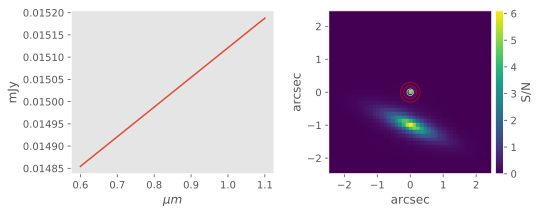

In [18]:
g.calculation_result = r

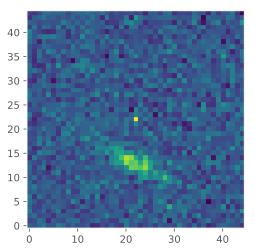

In [19]:
plt.imshow(g.calculation_result['2d']['detector'])

In [20]:
g.calculation_input

{'background': 'medium',
 'calculation': {'effects': {'background': True,
   'ipc': True,
   'saturation': True},
  'noise': {'crs': True,
   'darkcurrent': True,
   'ffnoise': True,
   'readnoise': True,
   'rn_correlation': True}},
 'configuration': {'detector': {'nexp': 1,
   'ngroup': 10,
   'nint': 1,
   'readmode': 'rapid',
   'subarray': 'full'},
  'dynamic_scene': True,
  'instrument': {'aperture': 'any',
   'disperser': None,
   'filter': 'z087',
   'instrument': 'wfirstimager',
   'mode': 'imaging'},
  'max_scene_size': 25,
  'scene_size': 5},
 'scene': [{'position': {'orientation': 0.0,
    'position_parameters': ['x_offset', 'y_offset', 'orientation'],
    'x_offset': 0.0,
    'y_offset': 0.0},
   'shape': {'geometry': 'point', 'shape_parameters': []},
   'spectrum': {'extinction': {'bandpass': 'v',
     'law': 'mw_rv_31',
     'unit': 'mag',
     'value': 0.0},
    'lines': [],
    'name': 'generic source',
    'normalization': {'norm_flux': 1.0,
     'norm_fluxunit': 'ujy